# Setup

In [1]:
import json
from itertools import islice

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
with open('data/vqa/raw/v2_OpenEnded_mscoco_test2015_questions.json') as f:
    ques = json.load(f)['questions']
print(len(ques), 'questions')

with open('results/cache/test_pred_butd.json') as f:
    pred_butd = json.load(f)
assert len(pred_butd) == len(ques)

with open('results/cache/test_pred_ban.json') as f:
    pred_ban = json.load(f)
assert len(pred_ban) == len(ques)

with open('results/cache/test_pred_mcan.json') as f:
    pred_mcan = json.load(f)
assert len(pred_mcan) == len(ques)

447793 questions


In [3]:
pred_butd_df = pd.DataFrame(pred_butd)
pred_butd_df.columns = ['answer_butd', 'question_id']

pred_ban_df = pd.DataFrame(pred_ban)
pred_ban_df.columns = ['answer_ban', 'question_id']

pred_mcan_df = pd.DataFrame(pred_mcan)
pred_mcan_df.columns = ['answer_mcan', 'question_id']

ques_df = pd.DataFrame(ques)

In [4]:
# remove duplicate columns
pred_df = pd.concat([pred_butd_df, pred_ban_df, pred_mcan_df], axis=1)
pred_df = pred_df.loc[:, ~pred_df.columns.duplicated()]
pred_df.head()

,answer_butd,question_id,answer_ban,answer_mcan
0,yes,262144000,no,no
1,baseball,262144001,baseball,baseball
2,no,262144002,no,yes
3,yes,262144003,yes,yes
4,yes,262144004,yes,no


In [5]:
# merge question with answers
df = pd.merge(pred_df, ques_df, how='inner', on='question_id')
columns = ['image_id', 'question_id', 'question', 'answer_butd', 'answer_ban', 'answer_mcan']
df = df.reindex(columns=columns)
df.head()

,image_id,question_id,question,answer_butd,answer_ban,answer_mcan
0,262144,262144000,Is the ball flying towards the batter?,yes,no,no
1,262144,262144001,What sport is this?,baseball,baseball,baseball
2,262144,262144002,Can you see the ball?,no,no,yes
3,262144,262144003,Is the pitcher wearing a hat?,yes,yes,yes
4,262144,262144004,Will he catch the ball in time?,yes,yes,no


In [6]:
# attention weights
att_weight_butd = np.load('results/cache/att_weight_butd.npz')['att']
att_weight_ban = np.load('results/cache/att_weight_ban.npz')['att']
att_weight_mcan = np.load('results/cache/att_weight_mcan.npz')['att'] / 14.0

In [7]:
# check attention weights
stat = pd.DataFrame({
    'butd': att_weight_butd.sum(axis=1),
    'ban': att_weight_ban.sum(axis=1),
    'mcan': att_weight_mcan.sum(axis=1)
})
stat.agg(['mean', 'var'])

,butd,ban,mcan
mean,1.000000e+00,1.000000e+00,1.000000e+00
var,2.019646e-14,1.461629e-15,4.354493e-16


# Visualization functions

183887


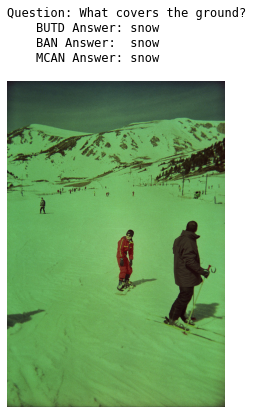

In [8]:
def show_image(image_id, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 6))
    image = plt.imread(f'data/vqa/raw/test2015/COCO_test2015_000000{image_id:06}.jpg')
    ax.imshow(image)

def visualize_ques_ans(df, idx=None, figsize=(6, 6)):
    if not idx:
        idx = np.random.choice(df.index)
    print(idx)
    row = df.loc[idx]
    
    fig, ax = plt.subplots(figsize=figsize)
    show_image(row['image_id'], ax)

    text = '''Question: {question}
    BUTD Answer: {answer_butd}
    BAN Answer:  {answer_ban}
    MCAN Answer: {answer_mcan}'''.format_map(row)
    ax.text(0, 1.05, text, transform=ax.transAxes, va='bottom', ha='left')
    ax.set_axis_off()
    
visualize_ques_ans(df)

385662


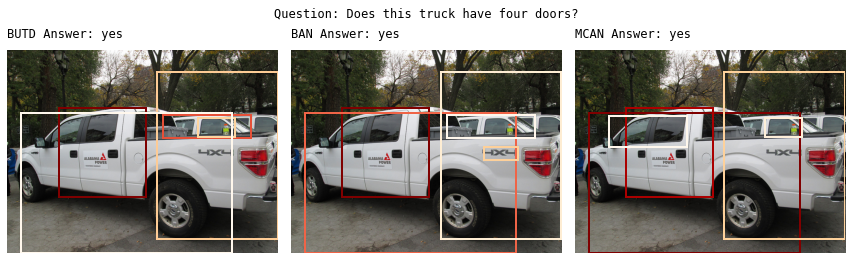

In [9]:
keys = ['answer_butd', 'answer_ban', 'answer_mcan']
atts = [att_weight_butd, att_weight_ban, att_weight_mcan]
    
def show_bbox(bboxes, att, ax, k):
    att = att[:len(bboxes)]
    idx = att.argsort()[::-1]
    att = att[idx]
    norm = mpl.colors.Normalize()
    norm(att[:k])
    colors = plt.cm.OrRd(norm(att))
    bboxes = bboxes[idx]

    for bbox, color in islice(zip(bboxes, colors), k):
        x0, y0, x1, y1 = bbox
        bbox_patch = mpl.patches.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor=color, lw=2)
        ax.add_patch(bbox_patch)

def visualize_bbox(row, idx=None, k=5, figsize=(12, 12), original=False, vertical=False):
    if not idx:
        idx = np.random.choice(df.index)
    print(idx)
    row = df.loc[idx]
    
    nrows, ncols = (2, 2) if original else (3, 1) if vertical else (1, 3)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    
    axs = axs.flatten()
    kwargs = dict(x=0, y=1.15, ha='left', transform=axs[0].transAxes) if original or vertical else \
        dict(x=0.5, y=1.15, ha='center', transform=axs[1].transAxes)
    
    fig.text(s=f'Question: {row["question"]}', va='bottom', **kwargs)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    with np.load(f'data/vqa/feats/test2015/COCO_test2015_000000{row["image_id"]:06}.jpg.npz') as npz:
        image_info = dict(zip(npz.files, npz.values()))
    
    if original:
        show_image(row['image_id'], axs[0])
        axs[0].set_axis_off()
        axs = axs[1:]
    
    for ax, key, att in zip(axs, keys, atts):
        show_image(row['image_id'], ax)
        text = f'{key.split("_")[1].upper()} Answer: {row[key]}'
        ax.text(0, 1.05, text, transform=ax.transAxes, va='bottom', ha='left')
        ax.set_axis_off()
        show_bbox(image_info['bbox'], att[row.name], ax, k)
    plt.tight_layout()

visualize_bbox(df)

# Find great examples

In [10]:
mask = pd.DataFrame({
    'butd-ban': df['answer_butd'] != df['answer_ban'],
    'butd-mcan': df['answer_butd'] != df['answer_mcan'],
    'ban-mcan': df['answer_ban'] != df['answer_mcan']
})
mask.sum()

butd-ban     117239
butd-mcan    134192
ban-mcan     119375
dtype: int64

In [11]:
all_diff_mask = (mask['butd-ban'] & mask['butd-mcan'] & mask['ban-mcan'])
all_diff_df = df[all_diff_mask]
print(len(all_diff_df), 'questions that three models predict different answers')
all_diff_df.head()

31544 questions that three models predict different answers


,image_id,question_id,question,answer_butd,answer_ban,answer_mcan
32,524301,524301000,What color is the cat?,brown and white,brown,black and white
45,16,16004,What is the players number?,13,21,16
90,262169,262169004,How tall is the fence?,8 feet,3 feet,6 feet
96,27,27002,Where did the shadow on the car come from?,car,street,tree
123,262177,262177002,What company name is visible?,apple,chiquita,yes


## Attention

- 10688  (2)
- 60384  (3) -
- 93705  (x) +
- 154722 (x)
- 174149 (x) +
- 178874 (x) -
- 237154
- 251212
- 349923 (x) -
- 406069

93705
174149


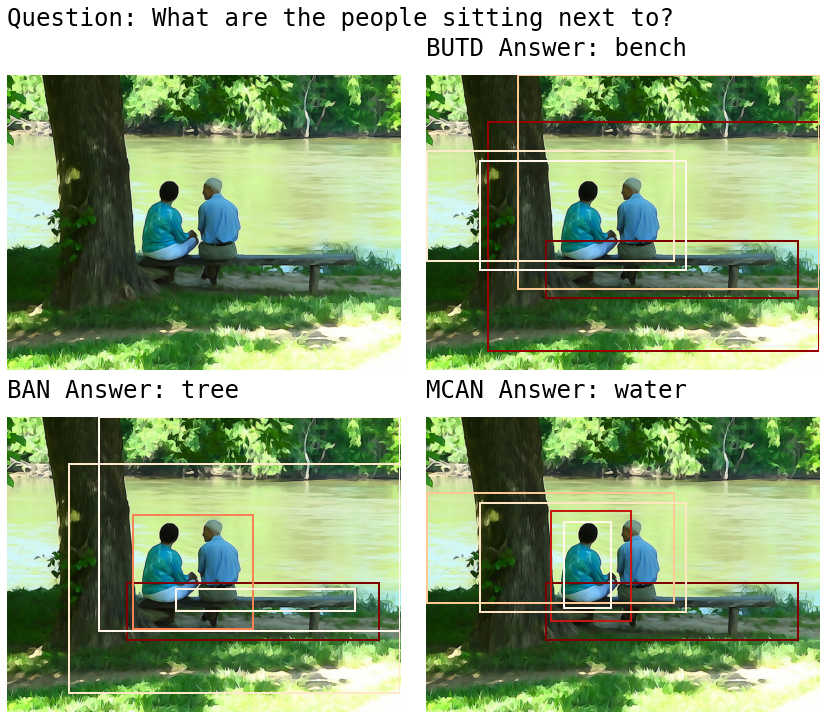

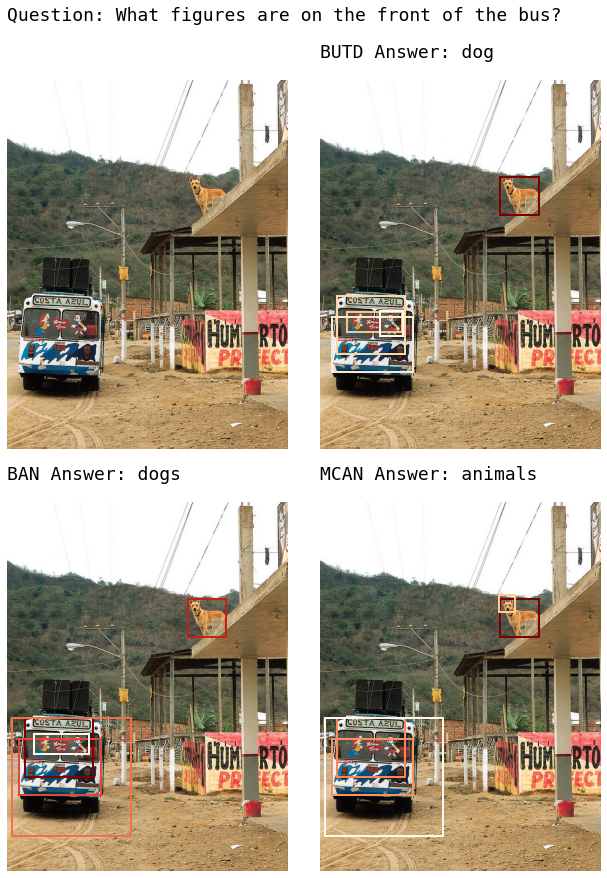

In [12]:
with plt.rc_context(rc={'font.size': 24}):
    visualize_bbox(all_diff_df, 93705, figsize=(12, 10), original=True)
    plt.savefig('figures/attention_0.png')
with plt.rc_context(rc={'font.size': 18}):
    visualize_bbox(all_diff_df, 174149, figsize=(9, 12), original=True)
    plt.savefig('figures/attention_1.png')

## Counting

some attentions are wrong too

- 4002
- 153785 (3) +
- 157295 (x) +
- 181344 (x) -
- 252601
- 259762 (x) -
- 262809 (x) -
- 321649
- 439527

In [13]:
how_many = all_diff_df['question'].str.lower().str.contains('how many')
how_many_df = all_diff_df[how_many]
print(len(how_many_df), '"how many" questions')

5178 "how many" questions


153785
157295


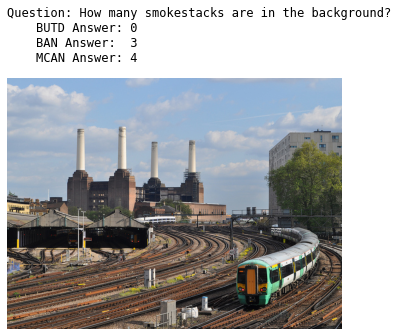

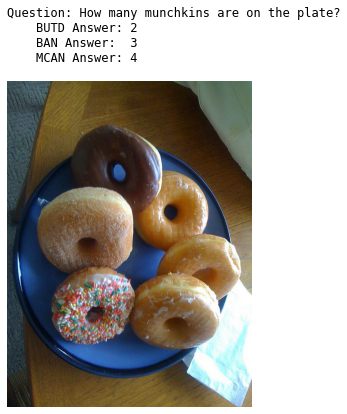

In [14]:
for i, idx in enumerate([153785, 157295]):
    visualize_ques_ans(how_many_df, idx)
    plt.savefig(f'figures/couting_{i}.png')

## Common sense

- 36565  (2)
- 62958
- 147692 (x) +
- 160484 (x) -
- 242620
- 315893 (x) -
- 317356 (x) +
- 318148 (3) -
- 416298 (2)

147692
317356


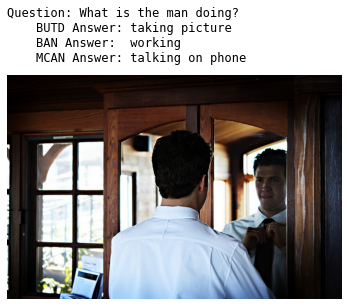

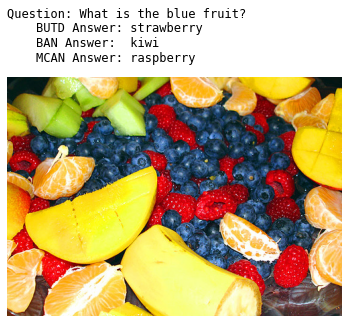

In [15]:
for i, idx in enumerate([147692, 317356]):
    visualize_ques_ans(all_diff_df, idx)
    plt.savefig(f'figures/common_sense_{i}.png')

## Strange

- 154722

## Text